In [1]:
import yaml
from os.path import join
import pandas as pd
import numpy as np
import sys  
import os
import shutil
from tqdm import tqdm
from IPython.display import display
sys.path.append(os.path.abspath("../generate_dataset"))
sys.path.append(os.path.abspath("../cohort_selection"))
sys.path.append(os.path.abspath("../preprocessing"))
sys.path.append(os.path.abspath("../models"))

from labelExtraction import *
from build_models import *
from preprocessing import *

from utils import *
from cohorts import get_first_stays, remove_mortality_frst_stay, add_inhospital_mortality_to_icustays, add_inunit_mortality_to_icustays

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
def set_seed(seed=2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    


def getfeaturesFromStaticTables(config):
    print('generating features from non-events tables...')

    data_dir = config[0]['data_dir']

    #get relevant data from ADMISSIONS table
    print('\nImporting data from admissions.csv...')
    path_admissions = join(data_dir, 'admissions.csv.gz')
    df_admissions = pd.read_csv(path_admissions)
    
    # get relevant data from icu_stays table
    print('\nImporting data from icustays...')
    path_icustays = join(data_dir, 'icustays.csv.gz')
    df_icustays= pd.read_csv(path_icustays)
    
    # get relevant data from PATIENTS table
    print('\nImporting data from patients...')
    path_patients = join(data_dir, 'patients.csv.gz')
    df_patients = pd.read_csv(path_patients)
          
    # merging dataframes
    print('\nMerging data from admissions, icustays, patients,...')
    df_merged = merge_on_subject_admission(df_icustays, df_admissions)
    df_merged = merge_on_subject(df_merged,df_patients)
    df_merged = prep_stays_dts(df_merged)
    #display(df_merged.head(10))
    return df_merged

In [2]:
def getfeaturesFromEventsTables(config, first_stays):
    feats= ['subject_id', 'hadm_id', 'stay_id', 'first_careunit','intime',
             'admission_type', 'admission_location',  'insurance',
             'language', 'marital_status', 'ethnicity', 'gender',
             'anchor_age', 'anchor_year_group', 'lostostay',   
             'intime_day', 'intime_hour','admittime_day','los_hrs','last_careunit',
             'admittime_hour', 'READMISSION-30', 'READMISSION-7', 'READMISSION-NTW',]
    
    if (config[2]['feat_set']['chart_events_feats']==1) & (config[2]['feat_set'] ['labevents_feats']== 0):
        first_stays_rm = roll_chart_items(config, first_stays)
        df = first_stays[feats].merge(first_stays_rm, how='inner', left_on=['stay_id'], right_on=['stay_id'])
        df = missing_rem(df)
        return df
        
    elif (config[2]['feat_set']['chart_events_feats']==1) & (config[2]['feat_set']['labevents_feats']== 1):
                
        first_stays_chart = roll_chart_items(config, first_stays)
        first_stays_lab = roll_lab_items(config, first_stays)
        first_stays_chart = first_stays[feats].merge(first_stays_chart, how='left', on=['stay_id'])
        
        first_stays_chart = first_stays_chart.merge(first_stays_lab, how='left', on=['stay_id'], suffixes=('', '_y'))
        first_stays_chart.drop(first_stays_chart.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
        first_stays_chart = missing_rem(first_stays_chart)
        del first_stays_lab
        
        return first_stays_chart
            
    else:# (config[2]['feat_set']['chart_events_feats']==0) & (config[2]['feat_set'] ['labevents_feats']== 1):
        
        print('Change config setting of features set to be appplied...') 
        

In [3]:
def feat_eng_transform(config, frst_stays):
    
    cats = ['first_careunit', 'last_careunit','admission_type', 'admission_location', 'discharge_location',  'insurance', 
            'language', 'marital_status', 'ethnicity', 'gender', 'anchor_year_group']
    
    frst_stays = encode(config, frst_stays,cats)
    frst_stays = extract_temporal_feats(frst_stays)
    
    
    drops= [ 
            'deathtime', 'edregtime', 'edouttime','hospital_expire_flag',
            'TRANSFERBACK', 'LESS_TAHN_30DAYS', 'LESS_TAHN_90DAYS', 'LESS_TAHN_7DAYS','NTW', 
            'MAX_OUTTIME', 'edregtime', 'edouttime', 'anchor_year', 
             'dod', 'COUNTS', 'DIFF']
    feats = [c for c in frst_stays if c not in drops ]
    frst_stays = frst_stays[feats].copy()
   
    return frst_stays

In [4]:
def train_models(labeled_data, models, targets):
    results = pd.DataFrame(columns=['model','target', 'ROCAUC', 'f1_score'])
    models_valid_rocauc = []
    models_test_rocauc = []
    models_f1 = []
    print(models)
    for model in models:
        for target in targets:
            print('start training....')
            print('model :', model)
            print('target', target)
            print('-------------------')
            v1 , v2, f1= build_models(labeled_data , model, tune= False, cv = 5, target_=target, test_size= .1)
            print(v1, v2)
            models_valid_rocauc.append(v1)
            models_test_rocauc.append(v2)

            row = {'model':model, 'target':target,  'ROCAUC':v2, 'f1_score':f1}
            results = results.append(row, ignore_index = True)
            
    return results

Your Config Setting:

[{'data_dir': '../data'}, {'subtask': {'atAdmit': 0, 'atDischarge': 1, 'isEarly': 0}}, {'feat_set': {'chart_events_feats': 1, 'labevents_feats': 1, 'static_feats': 1}}, {'wt_forrolling': {'dischwt_for_rolling': {24: 1, 48: 0}, 'erwt_for_rolling': {2: 0, 6: 0, 12: 1}}}, {'cat_encoding': {'le': 1, 'oh': 0, 'woe': 0}}, {'outlier_heal': {'Advanced': 0, 'byAnomalyScore': 1, 'normalization': 0}}, {'imp_type': {'mean': 1, 'median': 0, 'mice': 0}}, {'model': {'Logisticregression': 1, 'MLP': 0, 'XGB': 1}}, {'target': {'30': 1, '7': 1, 'ntw': 0}}, {'measure': {'accuracy': 0, 'f1_score': 1, 'recall': 0}}, {'GPU': 1}]

label extraction done before , labeled data exists ...

Reading labeled data  ...

Importing data from chartevents...
../data
first stays-chartevents row conts:  188839311
pivoting chartevents features...


  0%|          | 0/39265 [00:00<?, ?it/s]

pivot done !
starting resampling and rolling stats...


100%|██████████| 39265/39265 [13:34<00:00, 48.19it/s]


rolling done !

Loading data from labevents...
../data
first stays-labevents row counts:  7996071
pivoting labevents features...
pivot done !


  0%|          | 0/19513 [00:00<?, ?it/s]

starting resampling and rolling stats...


100%|██████████| 19513/19513 [04:09<00:00, 78.06it/s]


rolling done !


subject_id                                           int64
hadm_id                                              int64
stay_id                                              int64
first_careunit                                       int64
intime                                      datetime64[ns]
admission_type                                       int64
admission_location                                   int64
insurance                                            int64
language                                             int64
marital_status                                       int64
ethnicity                                            int64
gender                                               int64
anchor_age                                           int64
anchor_year_group                                    int64
lostostay                                          float64
intime_day                                           int64
intime_hour                                          int

Outliers Healing...
(39265, 137)
['Logisticregression', 'XGB']
start training....
model : Logisticregression
target 30
-------------------
train and test shapes: (31108, 143) (7778, 143)
train and test shapes: (31108, 143) (7778, 143)
fold: 0
train: 0.6497331881013926 val : 0.6325098679962493
--------------------
fold: 1
train: 0.6420253866972023 val : 0.6375268089352886
--------------------
fold: 2
train: 0.6374365733072525 val : 0.6428365411344757
--------------------
fold: 3
train: 0.6497668479188419 val : 0.642845943206572
--------------------
fold: 4
train: 0.6768524412956418 val : 0.653973830656523
--------------------
log reg  roc_auc=   0.6419385983858217
0.6419385983858217 0.6545111739074979
start training....
model : Logisticregression
target 7
-------------------
train and test shapes: (31108, 143) (7778, 143)
train and test shapes: (31108, 143) (7778, 143)
fold: 0
train: 0.6490765813445518 val : 0.6367232148522637
--------------------
fold: 1
train: 0.6677706441426083 val :

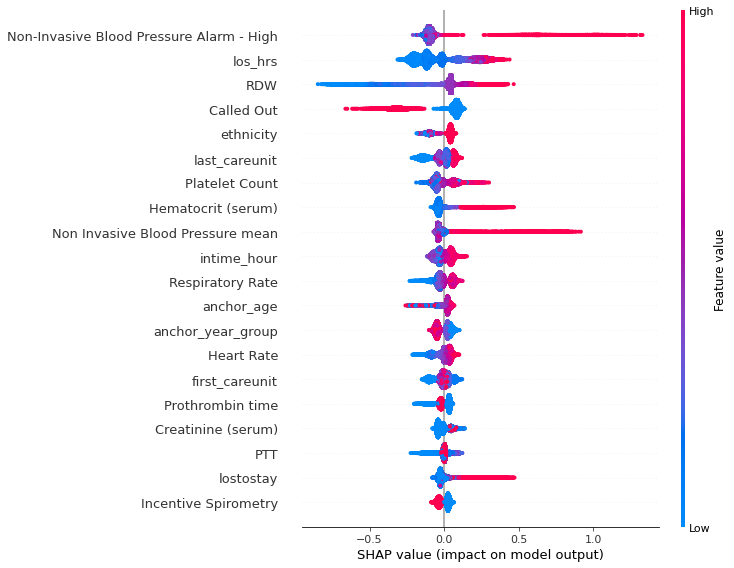

0.7492532248441257 0.7640416645092978
start training....
model : XGB
target 7
-------------------
train and test shapes: (31108, 143) (7778, 143)
fold :  0
[0]	train-auc:0.69236	test-auc:0.67116
[100]	train-auc:0.79555	test-auc:0.76447
[200]	train-auc:0.81255	test-auc:0.76957
[300]	train-auc:0.83240	test-auc:0.77480
[400]	train-auc:0.85133	test-auc:0.77858
[500]	train-auc:0.86696	test-auc:0.78134
[600]	train-auc:0.88091	test-auc:0.78227
[700]	train-auc:0.89259	test-auc:0.78291
[800]	train-auc:0.90229	test-auc:0.78390
[900]	train-auc:0.91093	test-auc:0.78366
[905]	train-auc:0.91137	test-auc:0.78357
0.7840620230721661
fold :  1
[0]	train-auc:0.70441	test-auc:0.69371
[100]	train-auc:0.79552	test-auc:0.77265
[200]	train-auc:0.81153	test-auc:0.77992
[300]	train-auc:0.83057	test-auc:0.78414
[400]	train-auc:0.84991	test-auc:0.78799
[500]	train-auc:0.86674	test-auc:0.78975
[600]	train-auc:0.88089	test-auc:0.79110
[700]	train-auc:0.89291	test-auc:0.79212
[800]	train-auc:0.90307	test-auc:0.79278

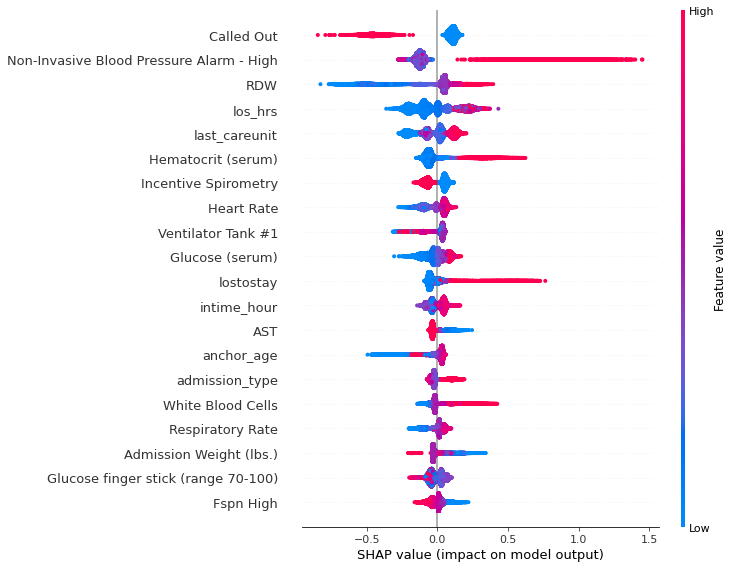

0.7486641200311632 0.8061856864661175


,model,target,ROCAUC,f1_score
0,Logisticregression,30,0.654511,0.298716
1,Logisticregression,7,0.669892,0.257150
2,XGB,30,0.764042,0.416813
3,XGB,7,0.806186,0.437917


In [5]:
if __name__ == "__main__":
    
    config = yaml.safe_load(open("../resources/config.yml"))
    print('Your Config Setting:\n')
    print(config)
    data_dir = config[0]['data_dir'];is_early = config[1]['subtask']['isEarly'];at_discharge = config[1]['subtask']['atDischarge'];at_admission = config[1]['subtask']['atAdmit'];
    er_wt_forrolling = config[3]['wt_forrolling']['erwt_for_rolling']; disch_wt_forrolling = config[3]['wt_forrolling']['dischwt_for_rolling']
    models  =list({k: v for k, v in config[7]['model'].items() if v== 1}.keys())
    targets = list({k: v for k, v in config[8]['target'].items() if v== 1}.keys())
    measures =  list({k: v for k, v in config[9]['measure'].items() if v== 1}.keys())
        
    # If labeled data exists
    if os.path.isdir('erStays'):
        
        print("\nlabel extraction done before , labeled data exists ...")
        print("\nReading labeled data  ...")
        frst_stays = pd.read_pickle('frst_stays.pkl')
        frst_stays = feat_eng_transform(config,frst_stays )
                      
        if is_early:
            
            stays_wh = frst_stays[frst_stays.los_hrs> 12]
            if ((config[2]['feat_set']['chart_events_feats']==1) | (config[2]['feat_set']['labevents_feats']==1)):
                labeled_data = getfeaturesFromEventsTables(config, stays_wh)
            #display(labeled_data.dtypes)
            print("Outliers Healing...")
            drps = ['intime', 'charttime', 'los_hrs','last_careunit']
            labeled_data.drop(drps, axis=1, inplace=True)
            labeled_data = outlier_heal(config, labeled_data)
            #display(labeled_data.dtypes)
            results = train_models(labeled_data, models, targets)
            display(results)
                           
                    
        elif at_discharge:
                           
            stays_wh = frst_stays[frst_stays.los_hrs> 24]
            if ((config[2]['feat_set']['chart_events_feats']==1) | (config[2]['feat_set']['labevents_feats']==1)):
                labeled_data = getfeaturesFromEventsTables(config, stays_wh)
            display(labeled_data.dtypes)
            print("Outliers Healing...")
            drps = ['intime', 'charttime']
            labeled_data.drop(drps, axis=1, inplace=True)
            
            labeled_data = outlier_heal(config, labeled_data)
            results = train_models(labeled_data, models, targets)
            display(results)
              
        else: #atAdmit
        
            labeled_data = frst_stays.copy()
            drps = ['intime', 'outtime', 'admittime', 'dischtime', 'los', 'los_hrs' ,'discharge_location','last_careunit']
            labeled_data.drop(drps, axis=1, inplace=True)
            display(labeled_data.dtypes)
                     
            results = train_models(labeled_data, models, targets)
            display(results)
                   
    # Label Extraction(once)
            
    else: 
        print('Label Extraction...')
        df_static_table = getfeaturesFromStaticTables(config=config)
        df_static_table = clean_temporals(df_static_table)
        print('Breaking stays by subjects ...')
        break_up_stays_by_subject(df_static_table, 'erStays')
        master_stays = label_extraction()
        print('Uniques, ICU_stays, visits, subjects:', master_stays.stay_id.unique().shape[0], master_stays.hadm_id.unique().shape[0],master_stays.subject_id.unique().shape[0])
        master_stays = prep_stays_dts(master_stays)
        print("Applying cohort getting  first stays by subject...")
        frst_stays =  master_stays.sort_values(by=['subject_id', 'intime']).groupby('subject_id').head(1)
        print('Uniques, ICU_stays, visits, subjects:', frst_stays.stay_id.unique().shape[0], frst_stays.hadm_id.unique().shape[0],frst_stays.subject_id.unique().shape[0])
        print("Applying cohort mortality on first stays...")
        frst_stays = remove_mortality_frst_stay(frst_stays)
        print('Uniques, ICU_stays, visits, subjects:', frst_stays.stay_id.unique().shape[0], frst_stays.hadm_id.unique().shape[0],frst_stays.subject_id.unique().shape[0])
        frst_stays.to_pickle('frst_stays.pkl') 
    